In [2]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [6]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [8]:
data = []

In [10]:
for i in range(2,18):
    if i == 12: 
        continue
    file_path = f'dataset/S{i}.pkl'
    file = open(file_path, 'rb')
    data1 = pickle.load(file, encoding='latin1')
    data.append(data1)

In [10]:
print(np.shape(data1['signal']['chest']['ACC']))

(4144000, 3)


In [13]:
print(np.shape(data1['signal']['wrist']['ACC']),  # Accelerometer
    np.shape(data1['signal']['wrist']['BVP']),  # Blood Volume Pulse
    np.shape(data1['signal']['wrist']['EDA']),  # EDA
    np.shape(data1['signal']['wrist']['TEMP']))

(189440, 3) (378880, 1) (23680, 1) (23680, 1)


In [47]:
 # combine_label = np.concatenate()
new = data

data = {
    'signal': {
        'chest': {
            'ACC': np.array([[0,0,0]]),
            'ECG': np.array([[0]]),
            'EMG': np.array([[0]]),
            'EDA': np.array([[0]]),
            'Temp': np.array([[0]]),
            'Resp': np.array([[0]])
        }
    },
     'label': np.array([0]),  # Target labels (replace with actual data)
}

for i in new:

    data['signal']['chest']['ACC'] = np.append(data['signal']['chest']['ACC'],i['signal']['chest']['ACC'],axis=0)
    data['signal']['chest']['ECG'] = np.append(data['signal']['chest']['ECG'],i['signal']['chest']['ECG'],axis=0)
    data['signal']['chest']['EMG'] = np.append(data['signal']['chest']['EMG'],i['signal']['chest']['EMG'],axis=0)
    data['signal']['chest']['EDA'] = np.append(data['signal']['chest']['EDA'],i['signal']['chest']['EDA'],axis=0)
    data['signal']['chest']['Temp'] = np.append(data['signal']['chest']['Temp'],i['signal']['chest']['Temp'],axis=0)
    data['signal']['chest']['Resp'] = np.append(data['signal']['chest']['Resp'],i['signal']['chest']['Resp'],axis=0)
    data['label'] = np.append(data['label'],i['label'],axis=0)



In [48]:
print(np.shape(data['signal']['chest']['ACC']))

(60807601, 3)


In [49]:
with open('Concat_data.pickle', 'wb') as handle:
    pickle.dump(data, handle)
    print("done")

done


In [56]:
import numpy as np
from sklearn.model_selection import train_test_split

# Combine chest data into a single array (features)
X = np.concatenate([data['signal']['chest']['ACC'], 
                          data['signal']['chest']['ECG'], 
                          data['signal']['chest']['EMG'], 
                          data['signal']['chest']['EDA'], 
                          data['signal']['chest']['Temp'], 
                          data['signal']['chest']['Resp']], axis=1)

# Labels (target)
y = data['label']
time_steps = 48646080  
num_features = X.shape[0] // time_steps

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")



Training data shape: (48646080, 8)
Test data shape: (12161521, 8)
Training labels shape: (48646080,)


In [61]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Combine chest sensor data into a single feature matrix
chest_data = [
    data['signal']['chest']['ACC'],  # Shape: (samples, 3)
    data['signal']['chest']['ECG'],  # Shape: (samples, 1)
    data['signal']['chest']['EMG'],  # Shape: (samples, 1)
    data['signal']['chest']['EDA'],  # Shape: (samples, 1)
    data['signal']['chest']['Temp'], # Shape: (samples, 1)
    data['signal']['chest']['Resp']  # Shape: (samples, 1)
]

# Concatenate all sensor data along axis 1
X = np.concatenate(chest_data, axis=1)  # Shape: (samples, features)

# Labels (target)
y = data['label']

# Normalize the features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Reshape into (samples, time_steps, num_features)
time_steps = 10  # Setting a smaller time_step for flexibility
num_samples, total_features = X_normalized.shape

# Ensure num_features is valid
if total_features % time_steps == 0:
    num_features = total_features // time_steps
else:
    # Adjust time_steps to fit data properly
    time_steps = 1  # Fallback to a single time step
    num_features = total_features

print(f"Reshaping data to (samples={num_samples}, time_steps={time_steps}, num_features={num_features})")

# Reshape data
X_reshaped = X_normalized.reshape(num_samples, time_steps, num_features)

# Convert labels to categorical for classification
y_categorical = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_categorical, test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")

# Build the LSTM model
model = models.Sequential()
model.add(layers.LSTM(64, input_shape=(time_steps, num_features), return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(y_categorical.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Save the model
model.save('LSTM_model_fixed.h5')



Reshaping data to (samples=60807601, time_steps=1, num_features=8)
Training data shape: (48646080, 1, 8)
Test data shape: (12161521, 1, 8)
Training labels shape: (48646080, 8)


C:\Users\iot\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
380048/380048 ━━━━━━━━━━━━━━━━━━━━ 798s 2ms/step - accuracy: 0.6860 - loss: 0.8016 - val_accuracy: 0.8733 - val_loss: 0.3447
Epoch 2/10
380048/380048 ━━━━━━━━━━━━━━━━━━━━ 785s 2ms/step - accuracy: 0.8674 - loss: 0.3561 - val_accuracy: 0.8835 - val_loss: 0.3056
Epoch 3/10
380048/380048 ━━━━━━━━━━━━━━━━━━━━ 758s 2ms/step - accuracy: 0.8865 - loss: 0.3041 - val_accuracy: 0.8945 - val_loss: 0.2809
Epoch 4/10
380048/380048 ━━━━━━━━━━━━━━━━━━━━ 775s 2ms/step - accuracy: 0.8962 - loss: 0.2767 - val_accuracy: 0.9085 - val_loss: 0.2436
Epoch 5/10
380048/380048 ━━━━━━━━━━━━━━━━━━━━ 783s 2ms/step - accuracy: 0.9042 - loss: 0.2559 - val_accuracy: 0.9095 - val_loss: 0.2423
Epoch 6/10
380048/380048 ━━━━━━━━━━━━━━━━━━━━ 778s 2ms/step - accuracy: 0.9106 - loss: 0.2396 - val_accuracy: 0.9195 - val_loss: 0.2151
Epoch 7/10
380048/380048 ━━━━━━━━━━━━━━━━━━━━ 771s 2ms/step - accuracy: 0.9151 - loss: 0.2282 - val_accuracy: 0.9170 - val_loss: 0.2230
Epoch 8/10
380048/380048 ━━━━━━━━━━━━━━━━━━━━ 76

Test accuracy: 0.9313055276870728


380048/380048 ━━━━━━━━━━━━━━━━━━━━ 348s 916us/step

Model Performance Metrics:
Accuracy: 0.9313
Precision: 0.9310
Recall: 0.9313
F1 Score: 0.9311


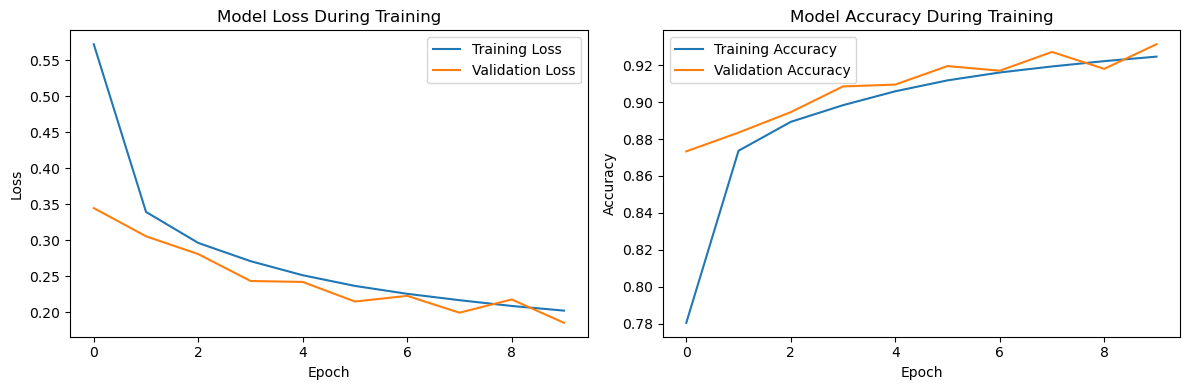

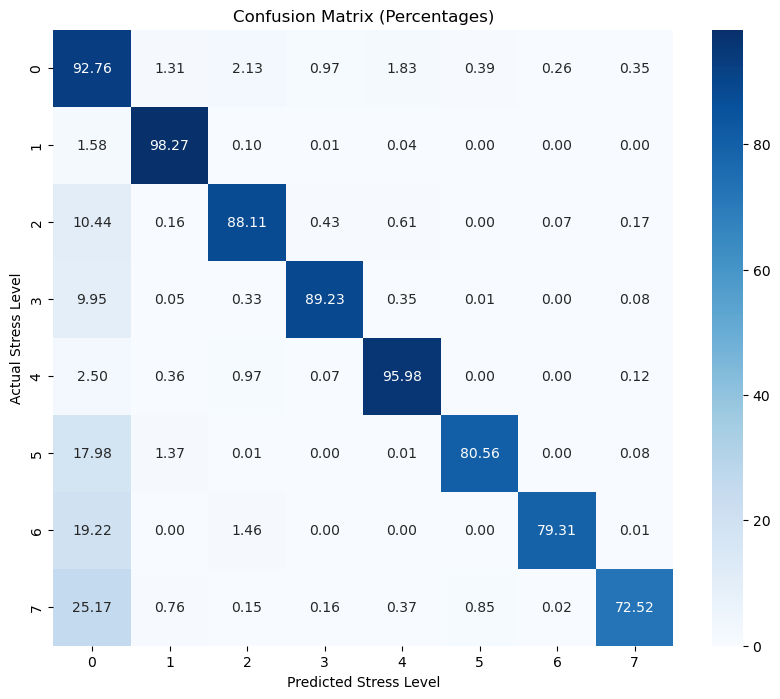

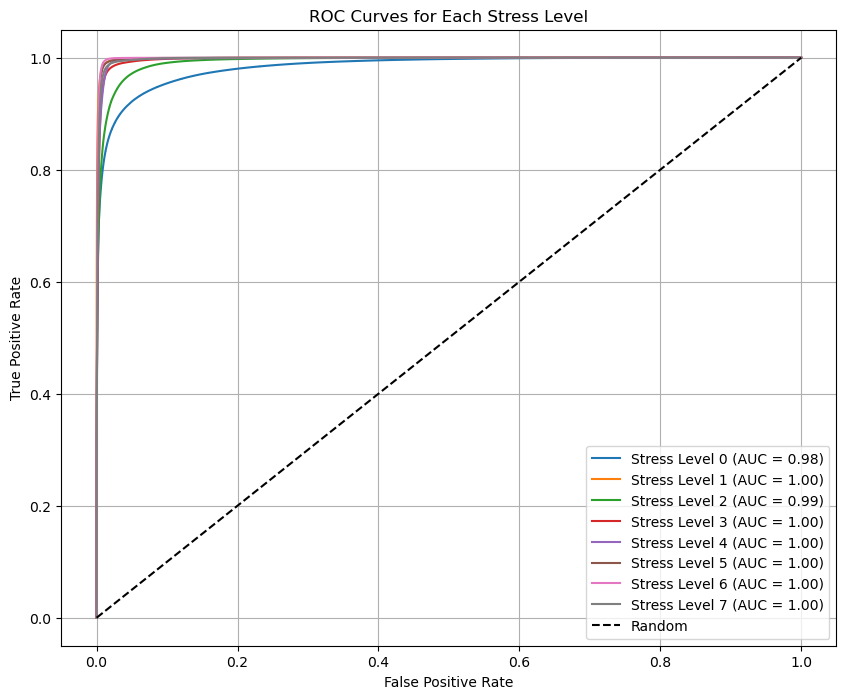


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93   5530242
           1       0.97      0.98      0.97   2465892
           2       0.90      0.88      0.89   1394895
           3       0.92      0.89      0.91    781112
           4       0.93      0.96      0.95   1652784
           5       0.80      0.81      0.80    110367
           6       0.85      0.79      0.82    110965
           7       0.77      0.73      0.75    115264

    accuracy                           0.93  12161521
   macro avg       0.88      0.87      0.88  12161521
weighted avg       0.93      0.93      0.93  12161521


Per-class Performance Metrics:

Stress Level 0:
Precision: 0.9321
Recall: 0.9276
F1-score: 0.9298

Stress Level 1:
Precision: 0.9668
Recall: 0.9827
F1-score: 0.9747

Stress Level 2:
Precision: 0.8972
Recall: 0.8811
F1-score: 0.8891

Stress Level 3:
Precision: 0.9194
Recall: 0.8923
F1-score: 0.9057

Stress Level 4:

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)

# Get model predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# 1. Calculate Basic Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 2. Plot Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 3. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted Stress Level')
plt.ylabel('Actual Stress Level')
plt.show()

# 4. ROC Curves
plt.figure(figsize=(10, 8))
n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Stress Level {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Stress Level')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 5. Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred))

# 6. Per-class Metrics
print("\nPer-class Performance Metrics:")
for i in range(n_classes):
    class_precision = precision_score(y_true == i, y_pred == i)
    class_recall = recall_score(y_true == i, y_pred == i)
    class_f1 = f1_score(y_true == i, y_pred == i)
    
    print(f"\nStress Level {i}:")
    print(f"Precision: {class_precision:.4f}")
    print(f"Recall: {class_recall:.4f}")
    print(f"F1-score: {class_f1:.4f}")

# Save metrics to a dictionary
metrics_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'confusion_matrix': cm,
    'confusion_matrix_percent': cm_percent
}

In [88]:
# 1. Calculate Basic Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Model Performance Metrics:
Accuracy: 0.9313
Precision: 0.9310
Recall: 0.9313
F1 Score: 0.9311


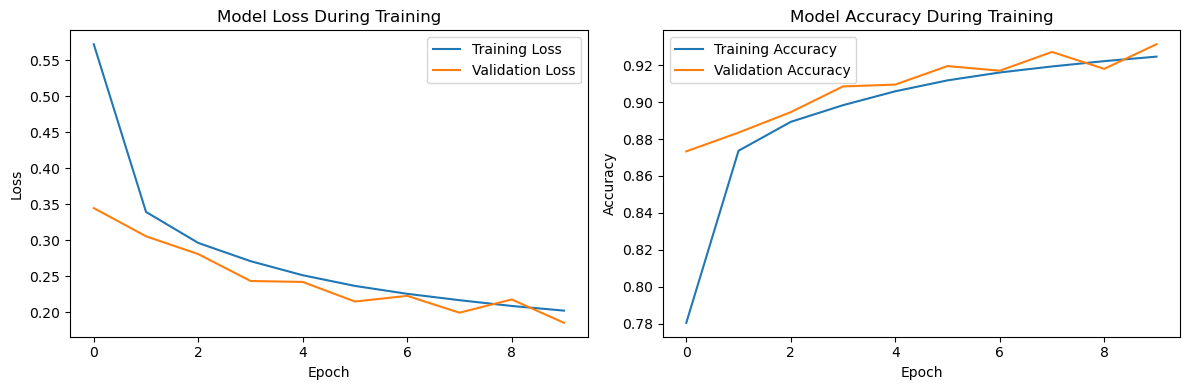

In [91]:
# 2. Plot Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

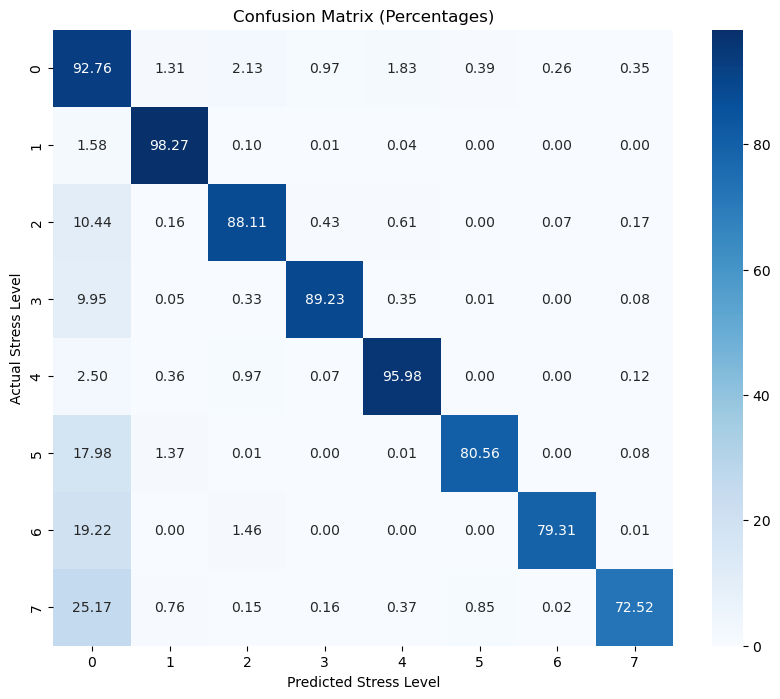

In [93]:
# 3. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted Stress Level')
plt.ylabel('Actual Stress Level')
plt.show()

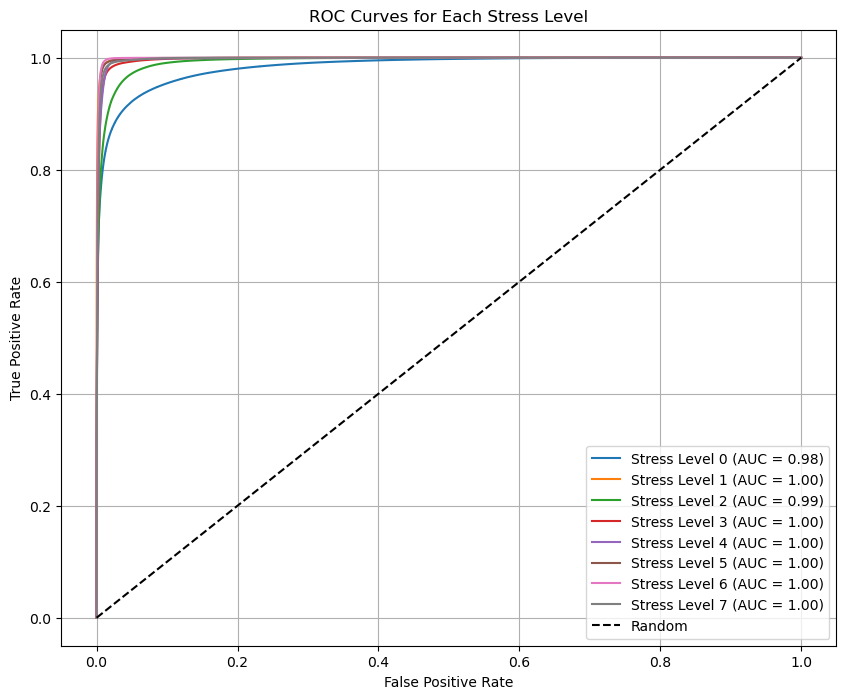

In [95]:
# 4. ROC Curves
plt.figure(figsize=(10, 8))
n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Stress Level {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Stress Level')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [97]:
# 5. Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred))


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93   5530242
           1       0.97      0.98      0.97   2465892
           2       0.90      0.88      0.89   1394895
           3       0.92      0.89      0.91    781112
           4       0.93      0.96      0.95   1652784
           5       0.80      0.81      0.80    110367
           6       0.85      0.79      0.82    110965
           7       0.77      0.73      0.75    115264

    accuracy                           0.93  12161521
   macro avg       0.88      0.87      0.88  12161521
weighted avg       0.93      0.93      0.93  12161521



In [99]:
# 6. Per-class Metrics
print("\nPer-class Performance Metrics:")
for i in range(n_classes):
    class_precision = precision_score(y_true == i, y_pred == i)
    class_recall = recall_score(y_true == i, y_pred == i)
    class_f1 = f1_score(y_true == i, y_pred == i)
    
    print(f"\nStress Level {i}:")
    print(f"Precision: {class_precision:.4f}")
    print(f"Recall: {class_recall:.4f}")
    print(f"F1-score: {class_f1:.4f}")


Per-class Performance Metrics:

Stress Level 0:
Precision: 0.9321
Recall: 0.9276
F1-score: 0.9298

Stress Level 1:
Precision: 0.9668
Recall: 0.9827
F1-score: 0.9747

Stress Level 2:
Precision: 0.8972
Recall: 0.8811
F1-score: 0.8891

Stress Level 3:
Precision: 0.9194
Recall: 0.8923
F1-score: 0.9057

Stress Level 4:
Precision: 0.9329
Recall: 0.9598
F1-score: 0.9462

Stress Level 5:
Precision: 0.7978
Recall: 0.8056
F1-score: 0.8017

Stress Level 6:
Precision: 0.8514
Recall: 0.7931
F1-score: 0.8212

Stress Level 7:
Precision: 0.7721
Recall: 0.7252
F1-score: 0.7480


In [101]:
# Save metrics to a dictionary
metrics_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'confusion_matrix': cm,
    'confusion_matrix_percent': cm_percent
}